In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [2]:
# hyperparameters
seed = 42
valid_size=0.3 # validation + testing
test_size=0.5 # tesing / (testing+validation)
learning_rate = 0.001
epochs = 10
batch_size = 2048
weight_decay = 0.0005
dropout = 0.5
embed_dim = 384
max_len = 400 # max length of the paper_ids of a author

random.seed(seed)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')
print(device)

cuda


In [3]:
# load data
df_cascade = pd.read_json("../processed_data/df_cascade.json")
df_authors = pd.read_json("../processed_data/df_authors.json")

sum_positive = 0
for id, row in df_cascade.iterrows():
    sum_positive += len(row['citation_authors'])
avg_negative = sum_positive // len(df_cascade)

In [4]:
# sentence-bert to get embeddings

# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer("all-MiniLM-L6-v2")

# abstract_ls = df_abstract['abstract'].tolist()
# for i in range(len(abstract_ls)):
#     if type(abstract_ls[i]) == float:
#         abstract_ls[i] = ""

# abstract_embeddings = model.encode(abstract_ls, convert_to_tensor=True)
# torch.save(abstract_embeddings, 'abstract_embeddings.pt')

# For gpu
loaded_tensor = torch.load('../processed_data/abstract_embeddings.pt').to(device)
# For cpu
# loaded_tensor = torch.load('../processed_data/abstract_embeddings.pt', map_location=torch.device('cpu'))

In [5]:
# add negative samples
df_cascade['negative_authors'] = [[] for _ in range(len(df_cascade))]
author_ls = df_authors['author_id'].tolist()
for index, row in df_cascade.iterrows():
    authors = row['citation_authors']
    temp_indices = []
    for _ in range(avg_negative):
        isInclude = True
        while(isInclude):
            rand_author_id = random.choice(author_ls)
            if rand_author_id in authors:
                continue
            else:
                isInclude = False
                temp_indices.append(rand_author_id)
    df_cascade.at[index, 'negative_authors'] = temp_indices


In [6]:
# split

train_data, temp_data = train_test_split(df_cascade, test_size=valid_size, random_state=seed)
val_data, test_data = train_test_split(temp_data, test_size=test_size, random_state=seed)

train_iter = [] # [paper_id, author_id, label]
for index, row in train_data.iterrows():
    paper_id = row['paper_id']
    for author in row['citation_authors']:
        train_iter.append([paper_id, int(author), 1])
    for negative in row['negative_authors']:
        train_iter.append([paper_id, int(negative), 0])

val_iter = []
for index, row in val_data.iterrows():
    paper_id = row['paper_id']
    for author in row['citation_authors']:
        val_iter.append([paper_id, int(author), 1])
    for negative in row['negative_authors']:
        val_iter.append([paper_id, int(negative), 0])

test_iter = []
for index, row in test_data.iterrows():
    paper_id = row['paper_id']
    for author in row['citation_authors']:
        test_iter.append([paper_id, int(author), 1])
    for negative in row['negative_authors']:
        test_iter.append([paper_id, int(negative), 0])

In [7]:
# data loader

class PairDataset(Dataset): # [paper_id, paper_ids of author_id, label]
  def __init__(self, x):
    self.x_paper = np.array(x)[:,0]
    self.x_author = np.array(x)[:,1]
    self.y = np.array(x)[:,2]
  
  def __len__(self):
    return len(self.x_paper)

  def __getitem__(self, idx):
    x1_sample = self.x_paper[idx] # paper_id
    x2_sample = df_authors.loc[df_authors['author_id'] == self.x_author[idx], 'paper_ids']
    x2_sample = x2_sample.values[0] # list of paper ids

    # pad to max length of paper_ids
    # already known that loaded_tensor[0] is embedding of empty string
    x2_sample = np.array(x2_sample + [0] * (max_len - len(x2_sample)))
    y_sample = np.array(self.y[idx])
    
    return x1_sample, x2_sample, y_sample

train_data = PairDataset(train_iter)
valid_data = PairDataset(val_iter)
test_data = PairDataset(test_iter)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [8]:
len(train_iter), len(val_iter), len(test_iter)

(481380, 105590, 105372)

In [9]:
for paper_id, author_id_ls, label in train_loader:
    print(paper_id.shape)
    print(author_id_ls.shape)
    print(label.shape)
    break
print(len(train_loader)) # how many batches

torch.Size([2048])
torch.Size([2048, 400])
torch.Size([2048])
236


In [10]:
# model
class ConvClassifier(nn.Module):
    def __init__(self, embed_dim, hidden_dim, out_chaennels, dropout=0.5, kernel_size = [2, 3, 4]):
        super(ConvClassifier, self).__init__()
        self.fc_x1 = nn.Linear(embed_dim, hidden_dim)
        self.convs = nn.ModuleList(
            [
                nn.Sequential(nn.Conv2d(1, out_chaennels, (kernel, embed_dim)), nn.LeakyReLU())
                for kernel in kernel_size
            ]
        )
        self.fc_x2 = nn.Linear(out_chaennels * len(kernel_size), hidden_dim)
        self.fc_x3 = nn.Linear(hidden_dim*2, 2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x1_idx, x2_idxs):
        # Retrieve sentence embeddings
        x1_embedding = loaded_tensor[x1_idx]
        x2_embeddings = [loaded_tensor[idx] for idx in x2_idxs]

        # Process x1 embedding
        y1 = self.fc_x1(x1_embedding)
        # Process x2 embeddings
        y2_representations = []
        for emb in x2_embeddings:
            y2_rep = emb.unsqueeze(0)  # Add unsqueeze(0) to make the shape [1, embed_dim]
            y2_representations.append(y2_rep)
        y2 = torch.cat(y2_representations, dim=0)
        y2 = y2.unsqueeze(1)
        
        # y2.shape = [batch_size, Cin=1, max_len, embed_dim]
        ys = [conv(y2).squeeze(3) for conv in self.convs]  
        ys = [F.max_pool1d(y, y.size(2)).squeeze(2) for y in ys]
        y2 = torch.cat(ys, 1)
        y2 = self.dropout(y2)
        # y2.shape = [batch_size, out_channels * len(kernel_size)]
        # y2 = y2.view(y2.size(0), -1)
        y2 = self.fc_x2(y2)

        # Concatenate y1 and y2
        # shape = [batch_size, hidden_dim * 2]
        final_output = torch.cat([y1, y2], dim=-1)        
        y_final = self.fc_x3(final_output)

        return y_final

In [11]:
model = ConvClassifier(embed_dim=embed_dim, hidden_dim=32, out_chaennels=16, dropout=dropout).to(device)
print(torchinfo.summary(model))

Layer (type:depth-idx)                   Param #
ConvClassifier                           --
├─Linear: 1-1                            12,320
├─ModuleList: 1-2                        --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  12,304
│    │    └─LeakyReLU: 3-2               --
│    └─Sequential: 2-2                   --
│    │    └─Conv2d: 3-3                  18,448
│    │    └─LeakyReLU: 3-4               --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-5                  24,592
│    │    └─LeakyReLU: 3-6               --
├─Linear: 1-3                            1,568
├─Linear: 1-4                            130
├─Dropout: 1-5                           --
Total params: 69,362
Trainable params: 69,362
Non-trainable params: 0


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [13]:
# training loop
model.train()
training_loss = []
valid_loss = []
training_accuracy = []
valid_accuracy = []

for epoch in range(epochs):
    correct = 0 # for train_accuracy
    model.train()
    for index, [paper_id, author_id_ls, label] in enumerate(train_loader):
        optimizer.zero_grad()
        paper_id = paper_id.to(device)
        author_id_ls = author_id_ls.to(device)
        label = label.to(device)
        output = model(paper_id, author_id_ls)
        loss = criterion(output, label.long())
        loss.backward()
        optimizer.step()
        # Calculate training accuracy
        preds = torch.argmax(output, dim=1)
        correct += (preds == label).sum().item()

    training_accuracy.append(correct / len(train_loader.dataset))
    training_loss.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}], Training_Loss: {loss.item():.4f}')

    # Validation
    num_correct = 0 # for valid_accuracy
    model.eval()
    val_loss = 0.0
    for x1, x2, y in valid_loader:
        x = x1.to(device)
        x2 = x2.to(device)
        y = y.to(device)
        preds = model(x1, x2)
        loss = criterion(preds, y.long())
        val_loss += loss.item()
        num_correct += (torch.argmax(preds, dim=1) == y).sum().item()
    
    valid_accuracy.append(num_correct / len(valid_loader.dataset))
    val_loss /= len(valid_loader)
    valid_loss.append(val_loss)
    print(f'Validation loss: {val_loss:.4f}')

Epoch [1/10], Training_Loss: 0.5045
Validation loss: 0.5113
Epoch [2/10], Training_Loss: 0.4897
Validation loss: 0.5048
Epoch [3/10], Training_Loss: 0.4718
Validation loss: 0.5022
Epoch [4/10], Training_Loss: 0.5853
Validation loss: 0.5059
Epoch [5/10], Training_Loss: 0.4795
Validation loss: 0.4973
Epoch [6/10], Training_Loss: 0.5459
Validation loss: 0.4977
Epoch [7/10], Training_Loss: 0.4671
Validation loss: 0.4938
Epoch [8/10], Training_Loss: 0.4947
Validation loss: 0.4929
Epoch [9/10], Training_Loss: 0.4675
Validation loss: 0.5013
Epoch [10/10], Training_Loss: 0.5578
Validation loss: 0.4919


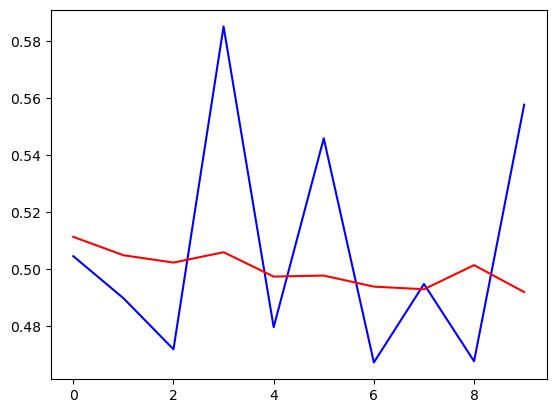

In [14]:
plt.plot(training_loss, 'b', valid_loss, 'r')

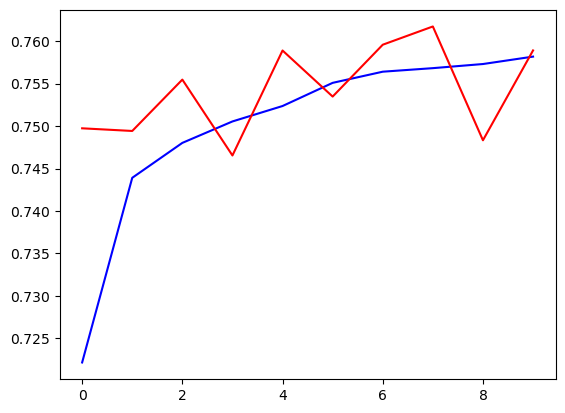

In [15]:
plt.plot(training_accuracy, 'b', valid_accuracy, 'r')

In [16]:
model.eval()
preds = []
labels = []
with torch.no_grad():
    running_hit = 0.0

    for x1, x2, y in test_loader:
        x1 = x1.to(device)
        x2 = x2.to(device)    
        y = y.to(device)
        output = model(x1, x2)
        pred = output.argmax(dim=1)
        labels.append(y)
        preds.append(pred)
    preds_cat = torch.cat(preds).to('cpu')
    labels_cat = torch.cat(labels).to('cpu')
    
    accuracy = accuracy_score(preds_cat, labels_cat)
    precision = precision_score(preds_cat, labels_cat)
    recall = recall_score(preds_cat, labels_cat)
    f1 = f1_score(preds_cat, labels_cat)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    print(f'Test Precision: {precision * 100:.2f}%')
    print(f'Test Recall: {recall * 100:.2f}%')
    print(f'Test F1 Score: {f1 * 100:.2f}%')

Test Accuracy: 76.05%
Test Precision: 75.23%
Test Recall: 77.52%
Test F1 Score: 76.36%
